# Clustering analysis and PCA #

### IMPORTANT: Please make sure that you are using the bash kernel to run this notebook.###
### IMPORTANT: Run the command below to git pull and make sure you are running the latest code!! ###
#### (Do this at the beginning of every session) ###

In [ ]:
cd /srv/scratch/training_camp/tc2016/`whoami`/src/training_camp
git stash 
git pull 

In [1]:
### Set up variables storing the location of our data
### The proper way to load your variables is with the ~/.bashrc command, but this is very slow in iPython 
export SUNETID="$(whoami)"
export WORK_DIR="/srv/scratch/training_camp/tc2016/${SUNETID}"
export DATA_DIR="${WORK_DIR}/data"
export FASTQ_DIR="${DATA_DIR}/fastq/"
export SRC_DIR="${WORK_DIR}/src/training_camp/src/"

export ANALYSIS_DIR="${WORK_DIR}/analysis/"
export TRIMMED_DIR="$ANALYSIS_DIR/trimmed"
export ALIGNMENT_DIR="$ANALYSIS_DIR/aligned/"
export TAGALIGN_DIR="$ANALYSIS_DIR/tagAlign/"
export PEAKS_DIR="$ANALYSIS_DIR/peaks/"
export SIGNAL_DIR="${ANALYSIS_DIR}signal/"
export FOLDCHANGE_DIR="${SIGNAL_DIR}foldChange/"
export COUNTS_DIR="${SIGNAL_DIR}counts/"

export YEAST_DIR="/srv/scratch/training_camp/saccer3/seq"
export YEAST_INDEX="/srv/scratch/training_camp/saccer3/bowtie2_index/saccer3"
export YEAST_CHR="/srv/scratch/training_camp/saccer3/sacCer3.chrom.sizes"

export TMP="${WORK_DIR}/tmp"
export TEMP=$TMP 
export TMPDIR=$TMP

export RLIBS=$RLIBS:"/usr/local/lib/R/site-library"

export MASTER_DATA="/srv/scratch/training_camp/data"

## Missing R packages##

When running the scripts in this section, if you get an error saying the gplots package has not been installed, you can install the package locally by  running the **3.5 Install R packages** notebook.

## The process_peaks.sh script ##

Cluster analysis is a simple way to visualize patterns in the data. By clustering peaks according to their signal across different time points, we may find groups of peaks that have similar behavior across these time points. By clustering samples according to their signal across peaks, we can perform a simple sanity check of data quality ‐ samples of the same time point should cluster together.

We have developed a script to perform all the following steps. NOTE: You will see data for all 32 samples on the heatmap, not just the one sample that you analyzed. In the preprocess_peaks.sh script, we point the code to analyze the fold change & counts file for all the data that we generated prior to the tutorial -- that way you can examine all the data without having to wait for all your samples to finish aligning! 

Couldn't open /srv/scratch/training_camp/tc2016/user1/analysis//peaks//all_merged.peaks.bed.gz , No such file or directory
Couldn't open /srv/scratch/training_camp/tc2016/user1/analysis//peaks//all_merged.peaks.bed.gz , No such file or directory
extracted signal
Error in file(file, "rt") : cannot open the connection
Calls: read.table -> file
In addition: Warning message:
In file(file, "rt") : cannot open file 'NA': No such file or directory
Execution halted
Error in asinh(signal.matrix) : 
  non-numeric argument to mathematical function
Calls: normalize.quantiles
Execution halted
combined the data

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

The "ward" method has been renamed to "ward.D"; note new "ward.D2"
Fontconfig warning: ignoring C.UTF-8: not a valid language tag
null device 
          1 

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

The "ward" method has been renamed to "ward.D";

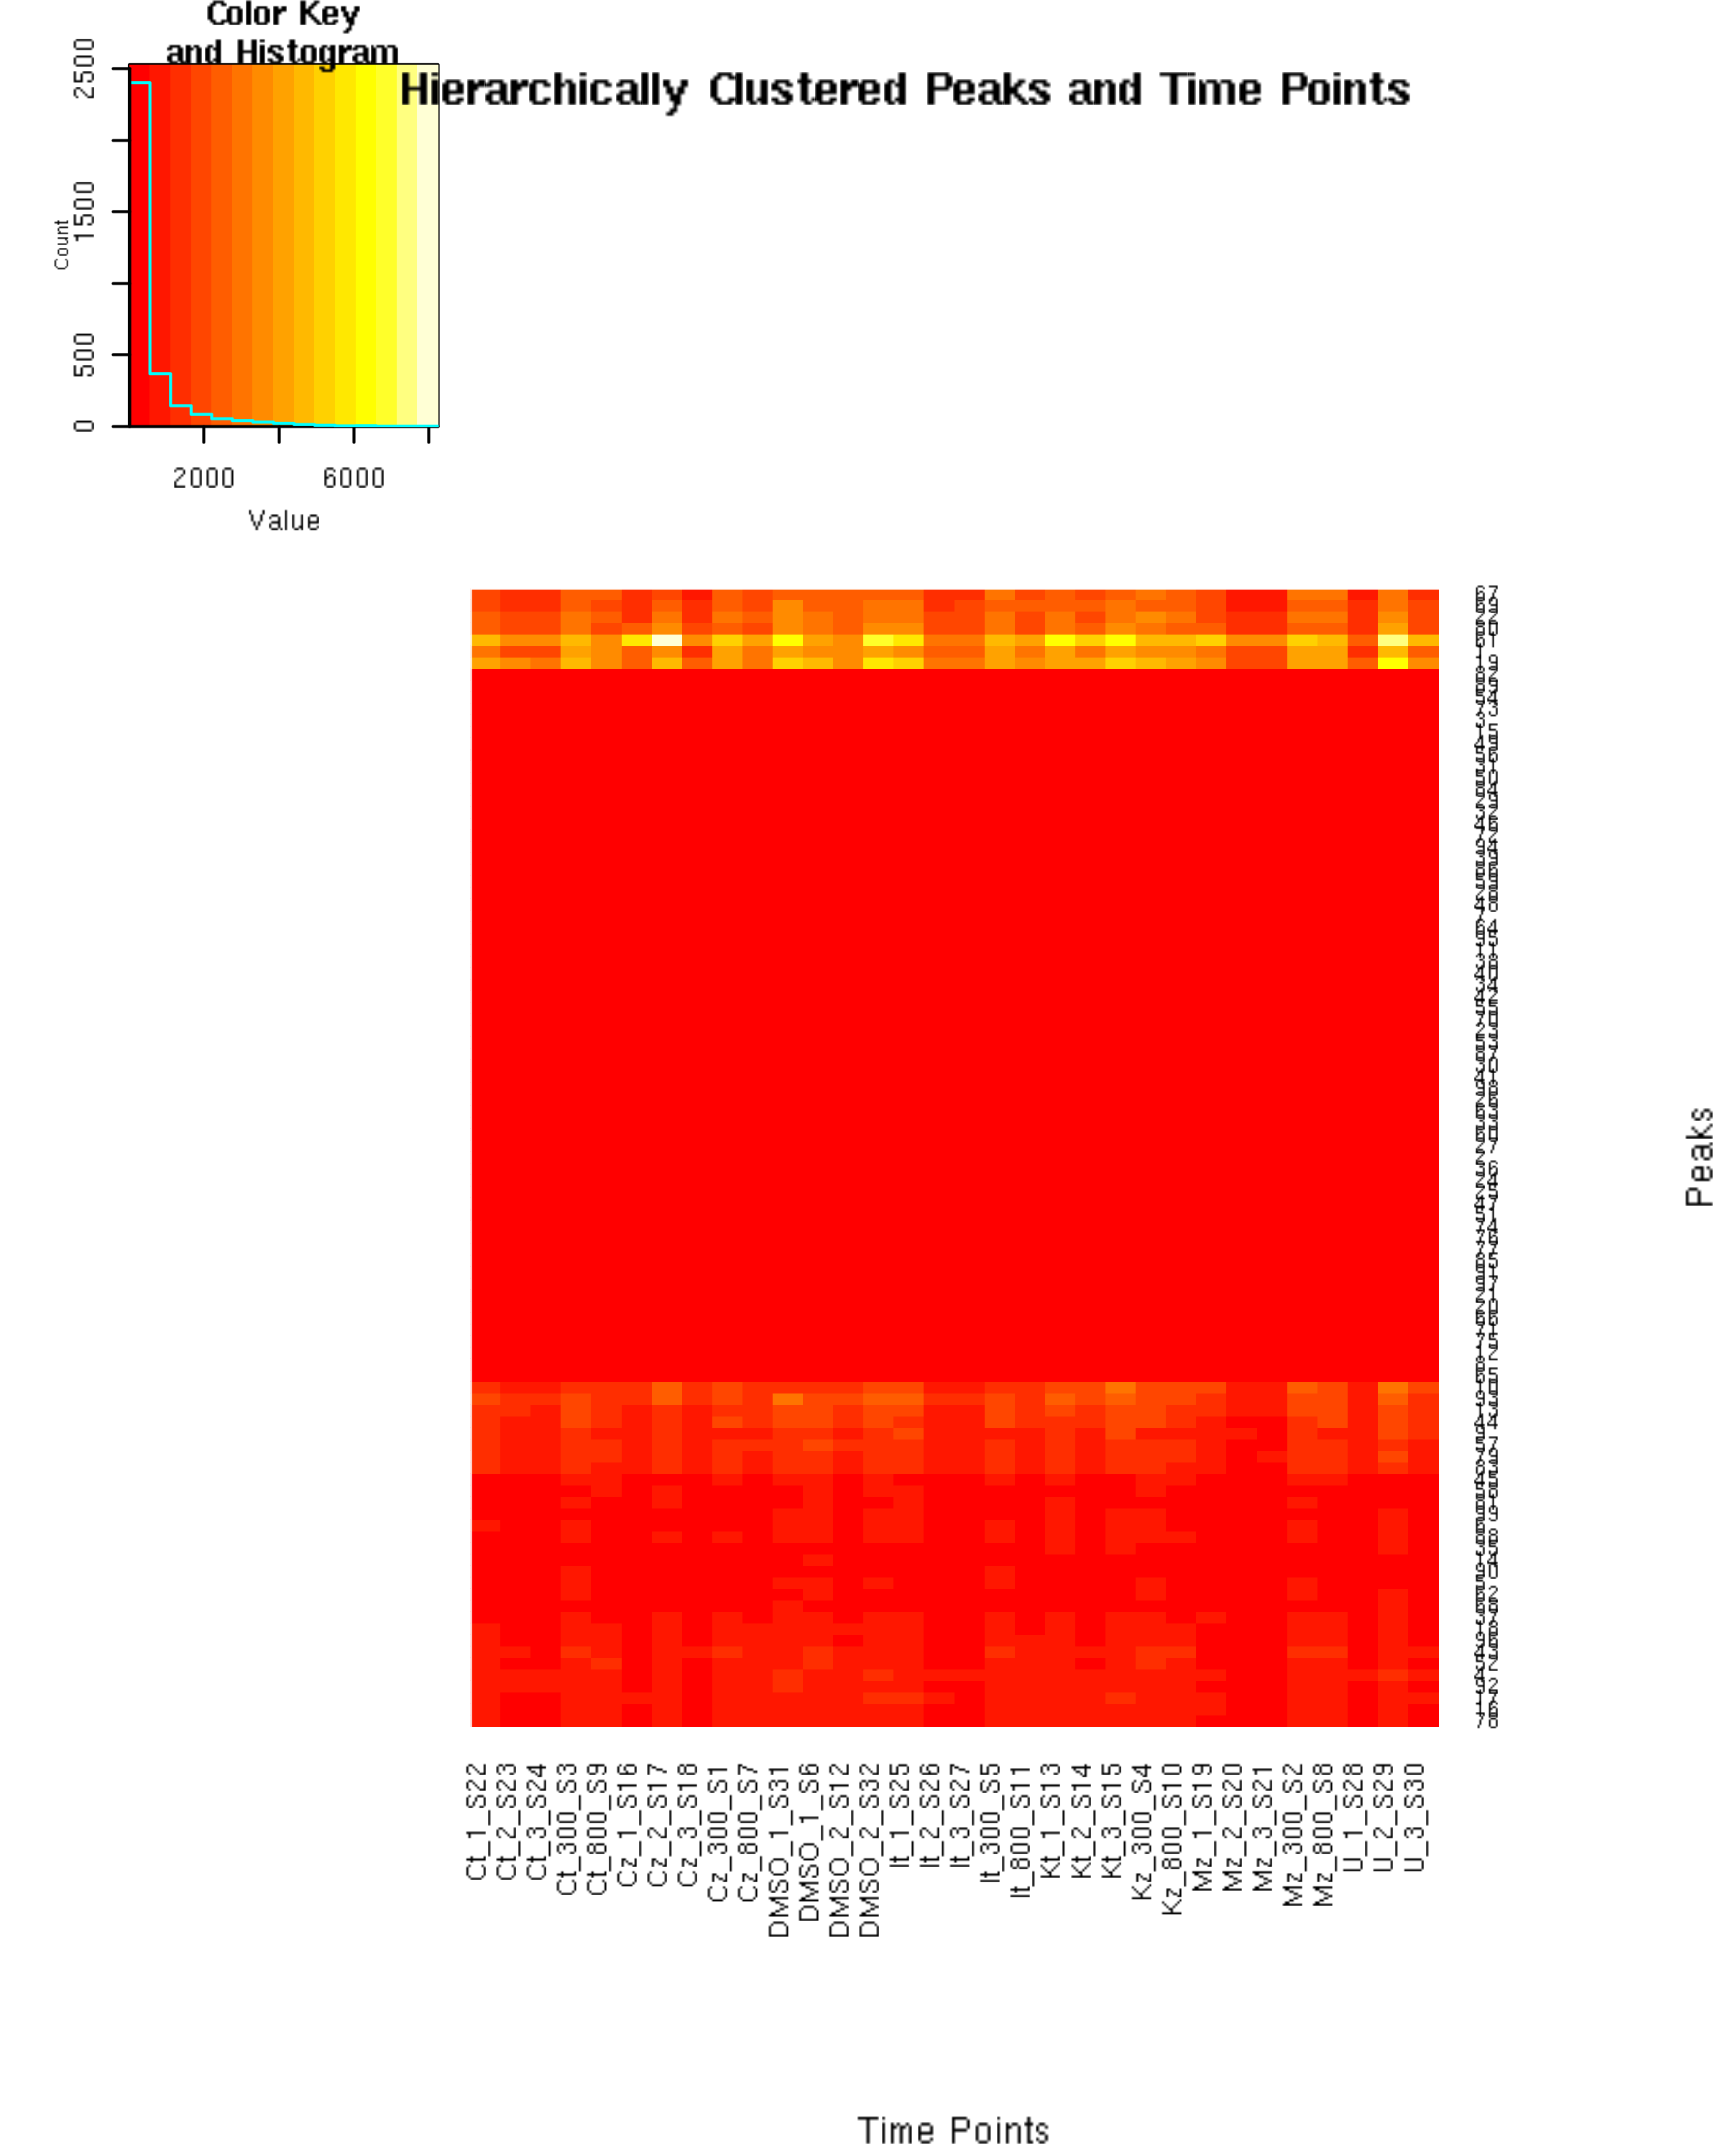

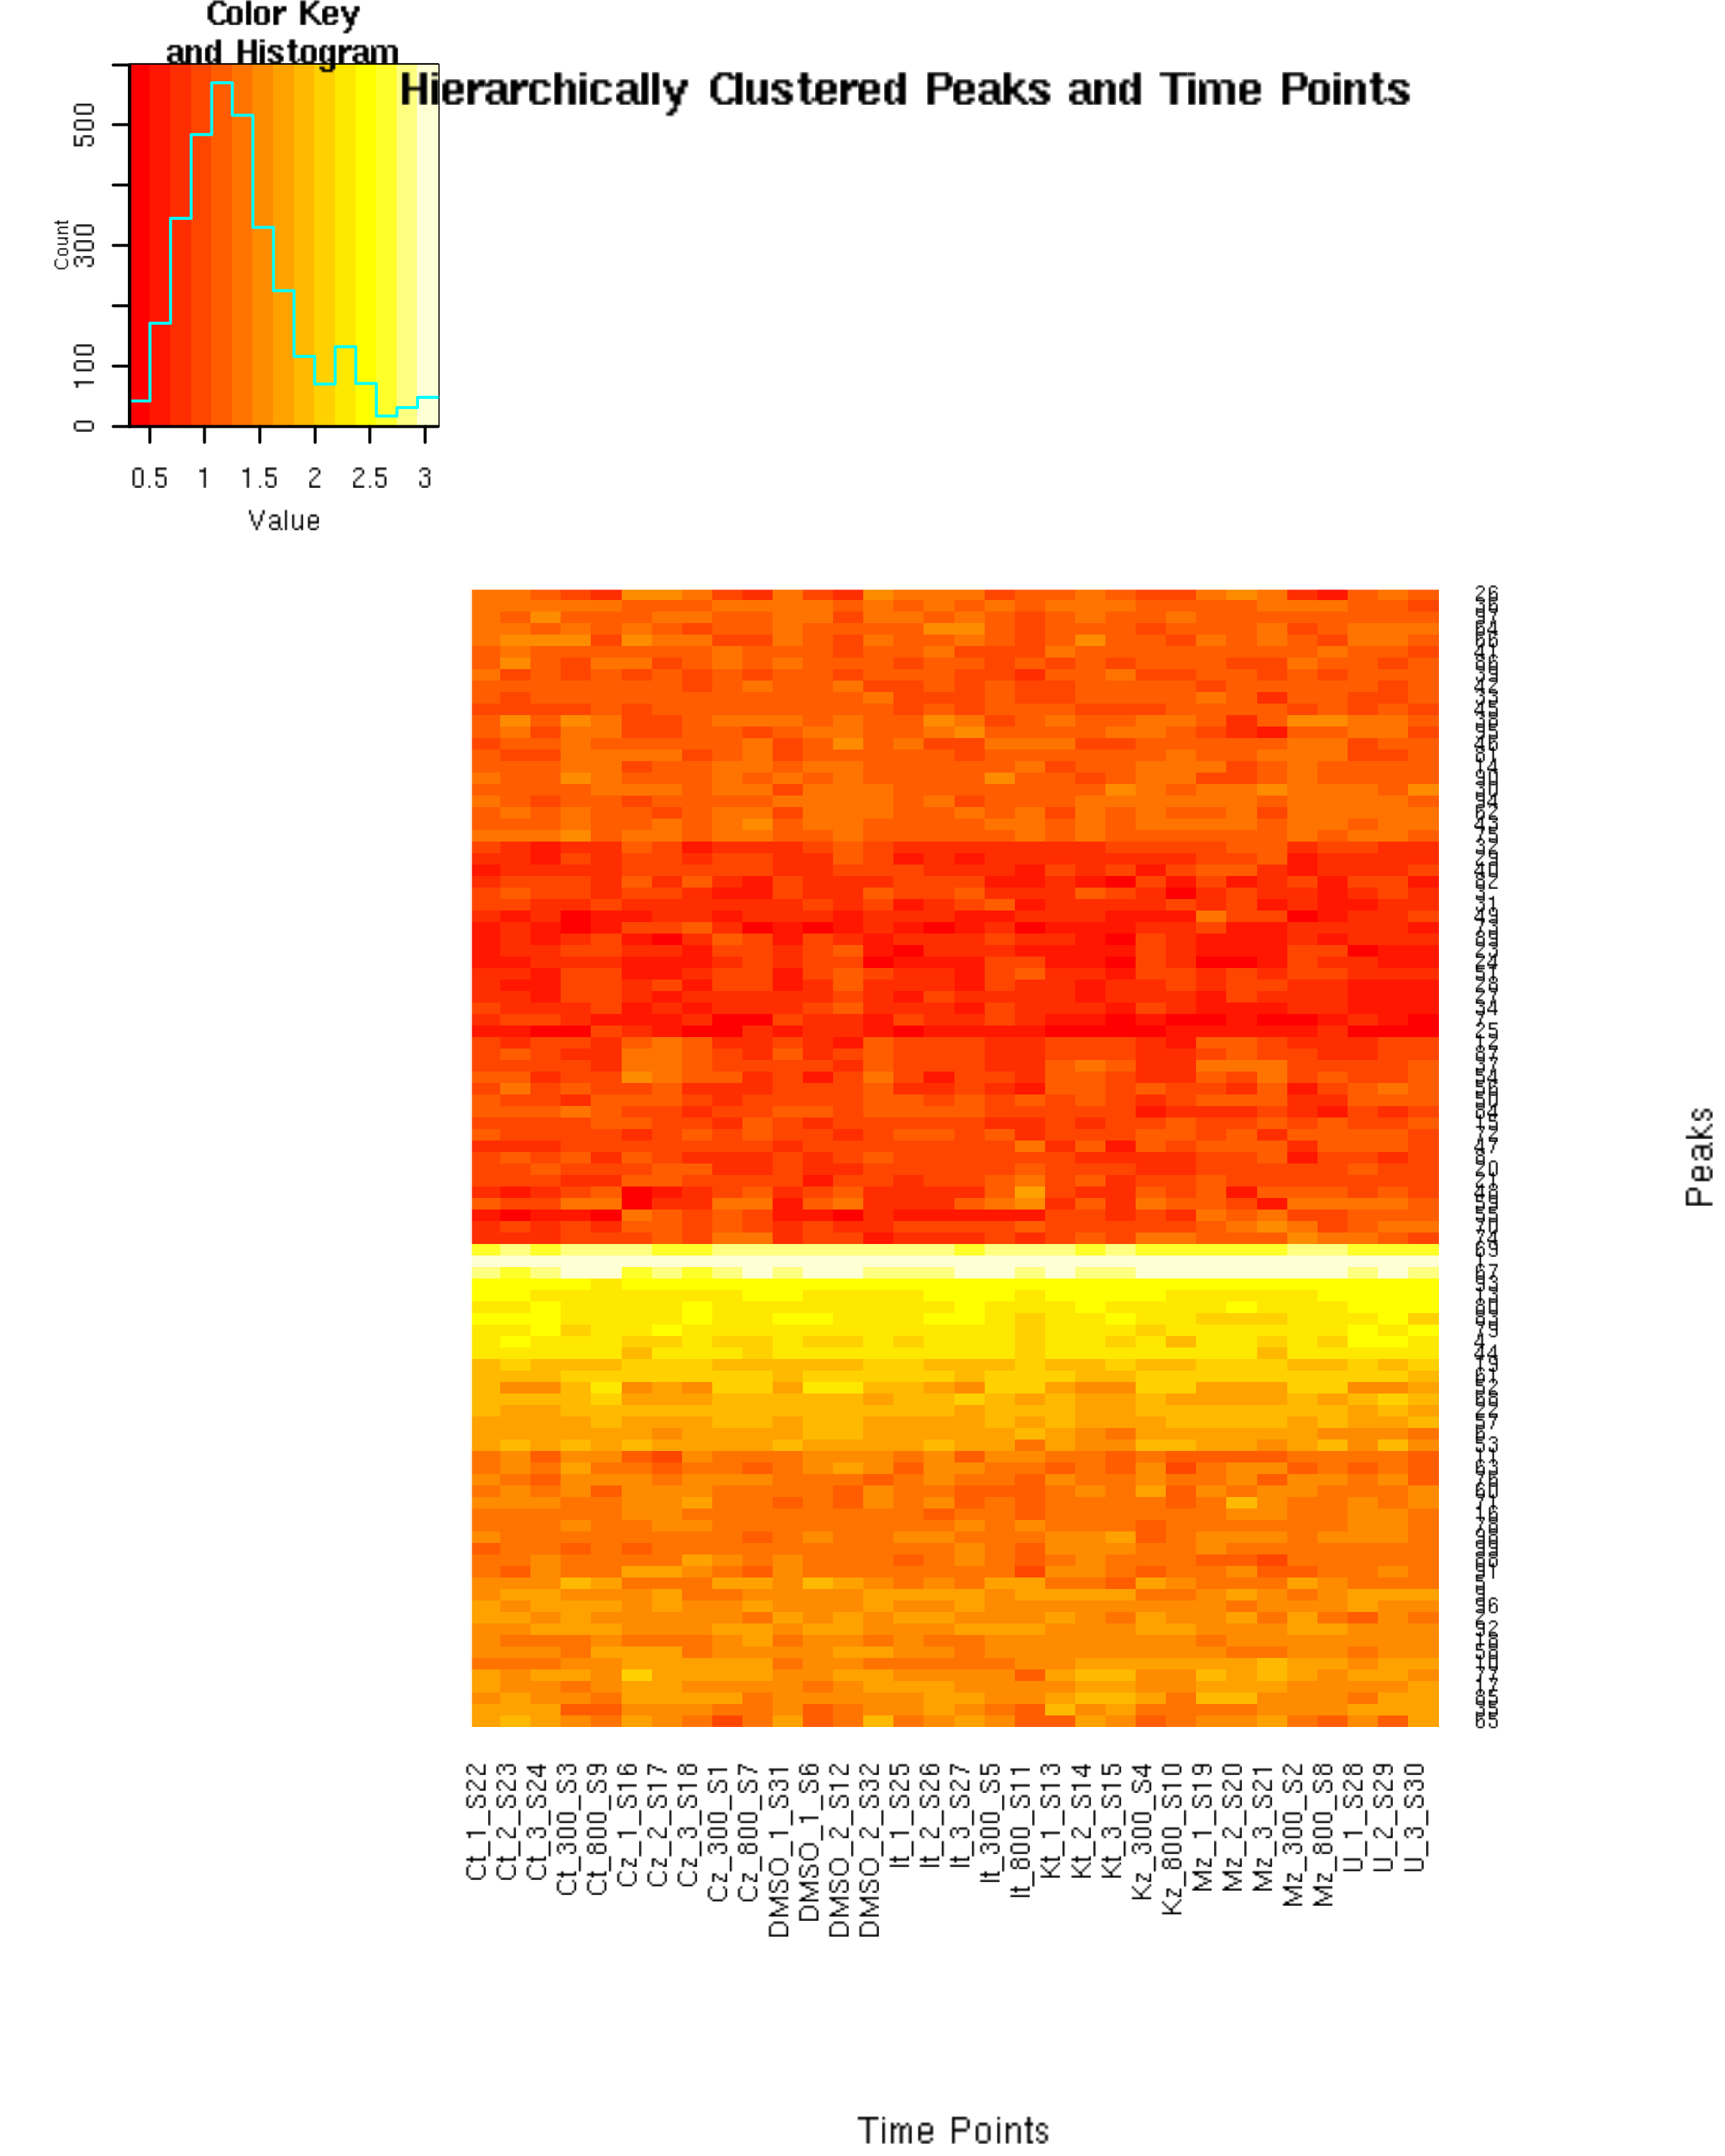

In [2]:
#Note: We are clustering on 8354 rows, so this script may take a long time to run!!!
${SRC_DIR}/process_peaks.sh
display < ${SIGNAL_DIR}/counts_cluster.png 
display < ${SIGNAL_DIR}/foldChange_cluster.png

## Heatmap generation ##

Note that the last step in the script above is to generate heatmaps. This step may fail if X11 is not installed. One solution is to copy the foldChange.tab file to your local computer, and then run:

**[path/to/]visualize_clusters.R foldChange.tab foldChange.png**

Note that visualize_clusters.R is obtained from the github repository of scripts: https://github.com/kundajelab/training_camp/blob/master/src/visualize_clusters.R

## PCA ##

PCA (Principal Component Analysis) is a way to identify the primary directions of variation in the data. It can also be used for very coarse-grained clustering of samples; similar samples will have similar coordinates along the principal axes.

We will perform PCA on foldChange.tab. The first step is to clean up the column labels in foldChange.tab with the following perl one-liner:

In [ ]:
cd $SIGNAL_DIR
perl -i".bak" -pe '$_ = $.==1 ? do {$_ =~ s/\/[^\s]+\///g; $_ =~ s/\"//g; $_ =~ s/\-/\./g; $_ =~ s/PooledReps_Sample/samp/g; $_} : $_' $MASTER_DATA/foldChange.tab
sed -i 's/\_R1.trimmed.nodup\_FE//g' $MASTER_DATA/foldChange.tab

We will now do PCA. We treat each sample as a single point in a very high dimensional space (where the dimensionality is equal to the number of genes the vary), and then we will perform dimensionality reduction in this space.

In [ ]:
cd $SIGNAL_DIR
$SRC_DIR/doPCA.R $MASTER_DATA/foldChange.tab

In [ ]:
#display the resulting PCA images
display < PCA_sdev.png
display < PC_1_vs_2.png 
display < PC_2_vs_3.png 
display < PC_1_vs_3.png
display < PC_3_vs_4.png 

In [ ]:
head -n20  pc1_rotation.txt

In [ ]:
head -n20 pc2_rotation.txt

This script will produce PCA_sdev.png, which shows the standard deviation explained by each of the principle components. Since there are only 32 datapoints, the effective dimensionality of our data is 32, even though there are thousands of genes; this is why there are only 32 PCs.

It also produces PC_[x]_vs_[y].png for components 1..3. How do you interpret the different principle components?

Finally, it produces the files pc[x]_rotation.txt for components 1..3, which show the contribution of each peak to the direction of the principle component; this file can be used to get a sense of which peaks are critical in defining the principle components, and in which direction (positive or negative). One interesting analysis we can do with these files is to sort the peaks by their contribution to the principle component in ascending or descending order, map the peaks to their nearest genes, and then used the ranked list with software such as GOrilla which accept a ranked list of genes and output which GO terms are overrepresented towards the top: (http://cbl-gorilla.cs.technion.ac.il/)

First, identify genes that are nearest to the peaks:

In [3]:
cd $PEAKS_DIR
bedtools closest -D a -a $MASTER_DATA/all_merged.peaks.bed.gz -b $SRC_DIR/yeast_tss_coords.bed > peaks2genes.bed

The following commands will sort the genes by their contribution to each principle component and then map them to their nearest gene:

In [ ]:
cd $SIGNAL_DIR
for pcFile in `ls pc*_rotation.txt`; do
    theBase=`basename ${pcFile}`
    cat $pcFile | sort -k 2r > "ascending_"$theBase
    cat $pcFile | sort -k 2rg > "descending_"$theBase
done
$SRC_DIR/mapToNearestPeak.py --sigPeakInputFiles ascending*.txt descending*.txt --peaks2genesFile $PEAKS_DIR/peaks2genes.bed

You can examine the output:

In [ ]:
ls nearestGene* 

Use the **head** command to print a specified number of lines from a file.
Use the **cat** command to print the full contents of the file.

In [ ]:
#example: print first 20 lines in nearestGenes_ascending_pc1_rotation.txt
head -n20 nearestGenes_ascending_pc1_rotation.txt

Exercise: copy & paste the lists of genes into GOrilla (http://cbl-gorilla.cs.technion.ac.il/) to discover over-represented GO terms.